# Q-Learning

In [89]:
import pandas as ps
import numpy as np
import random as rndm
import copy as cp
import time as time
from colorama import Back, Style
from IPython.display import clear_output
import matplotlib.pyplot as plt

## Problem Description

## Environment

In [90]:
FINNISH_REWARD=10
OBSTACLE_REWARD=-10
PRIZE_REWARD=10
EMPTY_REWARD=0

In [91]:
class environment:
    def __init__(self,file_location):
        self.init_map(file_location)
        self.loc=(0,0)
        self.got_prize=False
        self.actions=[(1,0),(0,1),(-1,0),(0,-1)]
        
    def init_map(self,file_location):
        map_file=open(file_location,"r")
        map_str=map_file.read()
        map_rows=map_str.split("\n")
        self.map=[]
        for row in map_rows:
            self.map.append(row.split())

    def get_state_size(self):
        return len(self.map)*len(self.map[0])*2
    
    def get_reward(self,loc):
        curr_block=self.map[loc[0]][loc[1]]
        if(curr_block=='.'):
            return EMPTY_REWARD
        if(curr_block =='F'):
            return FINNISH_REWARD if self.got_prize else EMPTY_REWARD
        if(curr_block =='P'):
            return PRIZE_REWARD
        if(curr_block =='O'):
            return OBSTACLE_REWARD

    def is_done(self,loc):  
        curr_block=self.map[loc[0]][loc[1]]
        return (self.got_prize and curr_block =='F') or curr_block =='O'

    def get_next_state(self,action):
        next_loc=tuple(map(sum, zip(self.loc, action)))
        next_prize=self.got_prize
        reward=self.get_reward(next_loc)
        if(self.map[next_loc[0]][next_loc[1]]=='P'):
            next_prize=True
            self.map[next_loc[0]][next_loc[1]]='.'

        self.loc = next_loc
        self.got_prize = next_prize
        return (next_loc[0], next_loc[1], int(next_prize)), reward, self.is_done(next_loc)

    def get_current_state(self):
        return (self.loc[0], self.loc[1], int(self.got_prize))

    def get_valid_actions(self):
        valid=[True,True,True,True]
        if(self.loc[0]==0):
            valid[2]=False
        if(self.loc[1]==0):
            valid[3]=False
        if(self.loc[0]==len(self.map)-1):
            valid[0]=False
        if(self.loc[1]==len(self.map[0])-1):
            valid[1]=False
        

        valid_actions=[]
        for i in range(4):
            if valid[i]:
                valid_actions.append(self.actions[i])
        
        return valid_actions


    def print(self):
        for i in range(len(self.map)):
            for j in range(len(self.map[0])):
                if (i,j)==self.loc :
                    print(Back.GREEN+self.map[i][j],end='')
                    print(Style.RESET_ALL,end='')
                else:
                    print(self.map[i][j],end='')
            print()

## Implementation

In [92]:
def get_state_index(state,env):
    return state[0]+len(env.map)*state[1]+len(env.map)*len(env.map[0])*state[2]

In [93]:
def Q_Learn(initial_env,display=False,episodes_count=20,max_step_per_episode=100,learning_rate=0.1,discount_factor=0.99,epsilon=0.1,initial_Q_table=None):
    if initial_Q_table is not None:
        Q_table=initial_Q_table
    else:
        Q_table=np.zeros((initial_env.get_state_size(), (len(initial_env.actions))))
    log=[]
    for _ in range(episodes_count):
        env=cp.deepcopy(initial_env)
        episode_reward=0
        for _ in range(max_step_per_episode):
            if(display):
                clear_output(wait=True)
                env.print()
                time.sleep(0.1)
            state=env.get_current_state()
            state_index=get_state_index(state,env)
            if rndm.uniform(0,1)<epsilon:
                action_index=int(rndm.uniform(0,3.99))
            else:
                if(np.min(Q_table[state_index,:])==np.max(Q_table[state_index,:])):
                    action_index=int(rndm.uniform(0,3.99))
                else:
                    action_index=np.argmax(Q_table[state_index,:])

            valid_actions=env.get_valid_actions()
            new_state,reward,done= env.get_next_state(valid_actions[action_index%len(valid_actions)])
            episode_reward+=reward
            Q_table[state_index][action_index]=(1-learning_rate)*Q_table[state_index][action_index]+learning_rate*(reward+discount_factor*np.max(Q_table[get_state_index(new_state,env),:]))

            if(done):
                if(display):
                    clear_output(wait=True)
                    env.print()
                    time.sleep(0.1)
                break

        log.append(episode_reward)
    return Q_table,log
            

## Results

In [96]:
#env=environment("./maps/easy.txt")
#env=environment("./maps/medium.txt")
env=environment("./maps/hard.txt")

In [105]:
table,log=Q_Learn(env,True,episodes_count=10,epsilon=0.3);

....O..O....
.O.....O....
OOO.........
P...OO.O.O.O
OOOOO..O.OFO


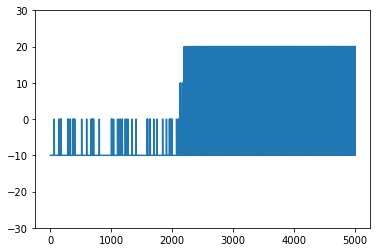

In [106]:
table,log=Q_Learn(env,False,episodes_count=5000);
plt.plot(log)
plt.ylim(-30,30)
plt.show()

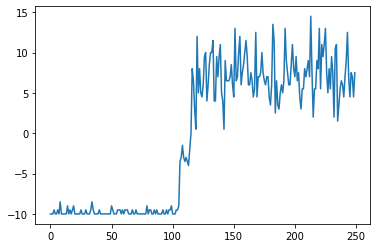

In [107]:
n=20
rewards_per_n_episodes = np.split(np.array(log),len(log)/n)
average_reward_per_n_episodes=[]
for reward_set in rewards_per_n_episodes:
    average_reward_per_n_episodes.append(np.average(reward_set));
    
plt.plot(average_reward_per_n_episodes)

In [109]:
Q_Learn(env,True,episodes_count=20,initial_Q_table=table,epsilon=0);

....O..O....
.O.....O....
OOO.........
....OO.O.O.O
OOOOO..O.OFO
